### Website for plot comparisons:
http://www.astro.utu.fi/~cflynn/galdyn/lecture4.html

# Imports 

In [10]:
import sympy as sp
import numpy as np
import math
from sympy import init_printing
from sympy.abc import rho,sigma,G, pi,phi
import pprint
init_printing() 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.linewidth'] = 2


# Constants  

In [11]:
G_cgs     = 6.67e-8 # grav constant cgs
G_solar_mass = 4.48e-3
k_boltz_cgs   = 1.380649e-16
solar_mass_cgs = 2e33 #grams
cgs_rho_to_solar_pc_rho = 1.48e22 # MULTIPLY cgs density by this to get solar mass pc^-3
cm_to_km = 1e-5 # MULTIPLY cm by this to get km
cm_to_pc = (3.086e18)**-1 # Multiply cm by this to get pc
g_to_sm  = (1.98e33)**-1  # Multiply g by this to get solar masses





# Symbolic math for isothermal/Plummer spheres  density & potentials

## Isothermal Sphere 

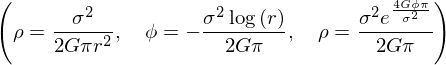

In [12]:
r = sp.symbols('r')
expr_rho = pow(sigma,2) / (2* pi*G*pow(r,2))
rho_eq = sp.Eq(rho, expr_rho)

expr_2   = pow(sigma,2) / ((2* pi*G))
expr_phi = sp.Mul(sp.exp( ( (4 * G * pi ) / (sigma ** 2)) * phi )) * expr_2 
rho_eq_2 = sp.Eq(rho, expr_phi)

rho_first_int = sp.integrate(expr_rho, r)
phi_eq = sp.integrate(rho_first_int, r)
phi_eq = sp.Eq(phi, phi_eq)
rho_eq, phi_eq, rho_eq_2

## Plummer Sphere

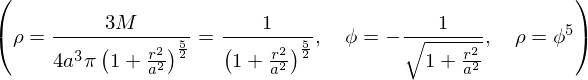

In [13]:
r_plum, a_plum, M_plum = sp.symbols(('r', 'a', 'M'), evaluate=False)
plummer_constants = sp.Mul(3, M_plum, evaluate=False) / \
    sp.Mul(4*pi, pow(a_plum, 3), evaluate=False)
expr_plum = plummer_constants * \
    pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))
expr_plum2 = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))

rho_eq_plum = sp.Eq(rho, expr_plum, evaluate=False)
rho_eq_plum = sp.Eq(rho_eq_plum, expr_plum2, evaluate=False)
# phi_eq_plum = sp.integrate(sp.integrate(rho_eq_plum,r),r)
# phi_eq_plum_int = sp.Eq(phi, phi_eq_plum,evaluate=True)

phi_eq_plum_int = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-1/2))
phi_eq_plum = sp.Eq(phi, -1*phi_eq_plum_int, evaluate=False)


rho_eq_plum_2 = sp.Eq(rho, phi**5, evaluate=False)

rho_eq_plum, phi_eq_plum, rho_eq_plum_2

# Analytic Functions

In [14]:
# PHI (r) ### ANALYTIC EQ
def phi_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1, _geometry="iso"):
    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _calc = (((_sigma ** 2.0) * np.log(_r)) / (2.0 * _Grav_const * np.pi))

    # plum
    if _geometry == "plum":
        _calc = (-1*_Grav_const*_M) * \
            (((_r**2.0) + (_a_plum ** 2.0)) ** (-1/2))

    return _calc

# RHO (r) ### ANALYTIC EQ


def rho_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
#         _calc = (_sigma ** 2.0) / (2.0 * _Grav_const * np.pi * (1.0 + _r**(2.0)))
        _calc = (_sigma ** 2.0) / (2.0 * _Grav_const * np.pi * (_r**(2.0)))


    # plum
    if _geometry == "plum":
        _calc = (3.0 * _M)/(4.0*np.pi) * \
            pow((1.0+pow((_r/_a_plum), 2.0)), -5/2)

    return _calc

# RHO (phi) ### ANALYTIC EQ


def rho_of_phi_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1,
                        _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _phi = phi_of_r_analytic(_r, _k_boltz=_k_boltz, _Grav_const=_Grav_const, _mean_mass=_mean_mass,
                                 _temp=_temp, _geometry=_geometry)
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        exp_term = np.exp(((4 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)))
        _calc = ((_sigma ** 2.0) / (2 * _Grav_const * np.pi)) * exp_term

    # plum
    if _geometry == "plum":
        _phi = phi_of_r_analytic(
            _r, _Grav_const=1, _a_plum=1, _M=1, _geometry=_geometry)
        _calc = np.abs(_phi**5.0)

    return _calc

# r (phi) ### ANALYTIC EQ


def r_of_phi_analytic(_r, _phi_func=phi_of_r_analytic, _k_boltz=1,
                      _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1,
                      _geometry="iso"):
    # iso
    if _geometry == "iso":
        _phi = phi_of_r_analytic(_r, _k_boltz=_k_boltz, _Grav_const=_Grav_const, _mean_mass=_mean_mass,
                                 _temp=_temp, _geometry=_geometry)
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _term = (2 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)
        _calc = np.exp(_term)

    # plum
    if _geometry == "plum":
        _phi = phi_of_r_analytic(
            _r, _Grav_const=_Grav_const, _a_plum=_a_plum, _M=_M, _geometry="plum")
        _calc = _a_plum*np.sqrt((_phi**-2.0) - 1.0)

    return _calc

# M (r) ### ANALYTIC EQ


def m_of_r_analytic(_r, _phi_func=phi_of_r_analytic, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1,
                    _a_plum=1, _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _constants = (2.0 * (_sigma ** 2.0)) / _Grav_const
        _calc = _constants * _r

    # plum
    if _geometry == "plum":
        _calc = ((_r**3.0)*_M) * (((_r**2.0) + (_a_plum ** 2.0)) ** (-3/2))

    return _calc

# Vcirc (r) ### ANALYTIC EQ


def vcirc_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1,
                        _geometry="iso"):

    _holder = np.zeros(_r.size)

    # iso
    if _geometry == "iso":
        _constants = np.sqrt((_k_boltz * _temp) / (2 * np.pi * _Grav_const))
        _calc = _holder + _constants

    # plum
    if _geometry == "plum":
        _calc = _r * pow((1+pow((_r/_a_plum), 2)), -3/4)

    return _calc

# Numerical Functions

## Derivatives 

In [15]:
# Take derivative of function (an array that is a function of x) W.R.T x
def take_deriv(_x, _y):
    """
    This function takes as input:
    _x = function inputs
    _y = f(function inputs _x)

    Outputs an array with shape (len(_x-1),2);
    containing two arrays: the bin centers for numerical derivative and numerical derivative(_x)
    """
    _dy_dx = np.diff(_y)/np.diff(_x)
    _x2 = (_x[:-1] + _x[1:]) / 2.0
    return np.array((_x2, _dy_dx))

# Poisson Solver for rho of r -> takes phi_of_r to start


def rho_solver_for_phi_of_r_poisson(_r, _phi_func_array, _deriv_func=take_deriv, _Grav_const=1):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _deriv_func     = calls derivative function defined above
    _Grav_constant  = Gravitational constant set equal to 1 as default

    Outputs an array with shape (len(_r),2);
    containing two arrays: the bin centers edges for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _RHS_constants = (4.0*np.pi*_Grav_const)
    if _Grav_const < 2 and _Grav_const > 0.5 : print("_Grav_const is one")
    # make derivative pieces
    _r, _d_phi_dr = _deriv_func(_x=_r, _y=_phi_func_array)

    # start calcs
    _first_term = (_r**2.0) * _d_phi_dr
    _r, _outer_derive = _deriv_func(_x=_r, _y=_first_term)

    # LHS of Poisson EQ
    _LHS = (_r**-2.0) * _outer_derive
    _calc = _LHS / _RHS_constants
    return np.array((_r, _calc))

# POISSON Rho solver for specified geometry


def rho_of_r_poisson_numerical(_r, _phi_func_array, _rho_func_array, _deriv_func=take_deriv, _normalize=False):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _rho_func_array = array containing rho(_r)
    _deriv_func     = calls derivative function defined above

    Outputs an array with shape (len(_r-2),2);
    containing two arrays: the bin centers for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _r_output, _calc = rho_solver_for_phi_of_r_poisson(
        _r, _phi_func_array, _deriv_func=_deriv_func)

    if _normalize == True:

        # Normalization Constant
        normalization_constant = _rho_func_array[0] / _calc[0]
#         print (_calc.shape)

        # Normalize and account for infs/nans
        if _r_output.shape[0] < _calc[np.isfinite(_calc)].shape[0]:
            _r_output = _r_output
        else:
            _r_output = _r_output[np.isfinite(_calc)]

        _calc = _calc[np.isfinite(_calc)] * normalization_constant

    return np.array((_r_output, _calc))

## Integrals

In [16]:
def trap_function(_input_array, _function_array, _cumulative_anti=True):
    """
    This function calculates the trapozoidal integral approximation of function_array accross the 
    entire function range

    This function takes as input:
    _input_array    = function inputs
    _function_array = f(function inputs _x) 

    Outputs an array with shape (len(_input_array-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array
    """
    # number of points
    _N = len(_function_array)
    # def dx
    _a, _b = 0, max(_input_array)
    # holding bins
    integral_result = np.zeros(len(_function_array)-1)
    x_values = np.zeros(len(_function_array)-1)
    # hard code first preset value
    previous_value = 0

    
    if _cumulative_anti == True:
        for ii in range(1, len(_function_array)):
            # get endpoints
            _f = _function_array[ii-1:ii+1]
            # store x value corresponding to right endpoint
            _x = _input_array[ii-1:ii+1]
            # grab the spacing
            _dx = np.diff(_x)
            # def endpoint
            _f_right = _f[1:]  # right endpoint
            _f_left = _f[:-1]  # left endpoint
            # integrate
            integral_result[ii-1] = ((_dx/2.0) *
                                     np.sum(_f_right + _f_left))+previous_value
            # store previous value for summation
            previous_value = integral_result[ii-1]
            # save x values using right bin edge
            x_values[ii-1] = _x[1:]
    if _cumulative_anti == False:
        for ii in range(1, len(_function_array)):
            _f = _function_array[ii-1:ii+1]
            # store x value corresponding to right endpoint
            _x = _input_array[ii-1:ii+1]
            # grab the spacing
            _dx = np.diff(_x)
#             print(_dx)
            # def endpoint
            _f_right = _f[1:]  # right endpoint
            _f_left = _f[:-1]  # left endpoint
            # integrate
            _calc = ((_dx/2.0) * np.sum(_f_right + _f_left))
            if _calc == np.nan:
                raise ValueError("nan in integrater")
            integral_result[ii-1] = _calc  #+previous_value
            # store previous value for summation
            #previous_value = integral_result[ii-1]
            # save x values using right bin edge
            x_values[ii-1] = _x[1:]
        integral_result = np.sum(integral_result)

    return np.array((x_values, integral_result))


def phi_solver_of_rho(_r, _analytic_rho, _analytic_phi, _int_function=trap_function, _Grav_const=1,
                      _normalize=True):
    """
    This function calculates the numerical phi(r) by using the poisson equation for spherically
    symmetric potentials

    This function takes as input:
    _r            = radius array
    _analytic_rho = array containing analytic rho(_r)
    _analytic_phi = array containing analytic phi(_r)
    _int_function = trapazoidal integral function defined above
    _Grav_const   = 1

    Outputs an array with shape (len(_r-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array

    _normalize determines whether or not you want numerical phi to be normalized by the analytic
    expression
    """
    # poisson
    _constants = 4.0*np.pi*_Grav_const
    if _Grav_const < 2 and _Grav_const > 0.5: print("_Grav_const is one")

    # integration stuff

    # get the integral
    _r, _first_term = _int_function(
        _input_array=_r, _function_array=_analytic_rho*_r**2.0)

    # get the second_integral
    _r, _second_term = _int_function(
        _input_array=_r, _function_array=_first_term/(_r**2.0))

    _calc = _second_term *_constants

    if _normalize == True:

        # Normalization Constant
        _normalization_constant = max(_calc)# - max(_analytic_phi)

#         _calc = _calc * _normalization_constant
        _calc = _calc - _normalization_constant

    return np.array((_r, _calc))

## Input Array 

In [17]:
_N = 100000
# r_array_2_iso = np.linspace(0.1, 100, _N)  # 0 to 40
r_array_2_iso = np.logspace(-1,2,_N) # 0.1 to 100

# Isothermal Sphere

## Variables for plotting

In [361]:
# Top Row
_geometry = "iso"

# Phi of r
r_iso, phi_of_r_analytic_iso = r_array_2_iso, phi_of_r_analytic(
    r_array_2_iso, _geometry=_geometry)


# rho of r
r_iso, rho_of_r_analytic_iso = r_array_2_iso, rho_of_r_analytic(
    r_array_2_iso, _geometry=_geometry)

# rho of r and derivatives
# Poisson normalized
r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_of_r_poisson_numerical(
    _r=r_iso, _phi_func_array=phi_of_r_analytic_iso,_rho_func_array=rho_of_r_analytic_iso,
    _deriv_func=take_deriv, _normalize=True)


# r of phi 
r_of_phi_iso, rho_of_r_of_phi_iso = r_of_phi_analytic(
    r_array_2_iso), rho_of_r_analytic(_r=r_of_phi_analytic(r_array_2_iso, _geometry=_geometry))

# phi of r numerical

_phi_of_r_x_vals, phi_of_r_numerical = phi_solver_of_rho(_r=r_iso, _analytic_rho=rho_of_r_analytic_iso,
                                                         _analytic_phi=phi_of_r_analytic_iso,
                                                         _int_function=trap_function, _normalize=False)

# rho(r) analytic -> phi(r) numerical -> rho(r) numerical
# logspace
r_iso_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test = rho_of_r_poisson_numerical(
    _phi_of_r_x_vals, _phi_func_array=phi_of_r_numerical, _rho_func_array=rho_of_r_analytic_iso,
    _deriv_func=take_deriv, _normalize=True)

# r_first_deriv, drho_dr  = take_deriv(rho_of_r_analytic(r_array_2_iso,_geometry=_geometry),_x=r_array_2_iso,_n=1)

# # second derivative`
# r_second_derive, d2rho_dr2  = take_deriv(rho_of_r_analytic(r_array_2_iso,_geometry=_geometry),_x=r_array_2_iso,_n=2)

_Grav_const is one
_Grav_const is one
_Grav_const is one


## Plots

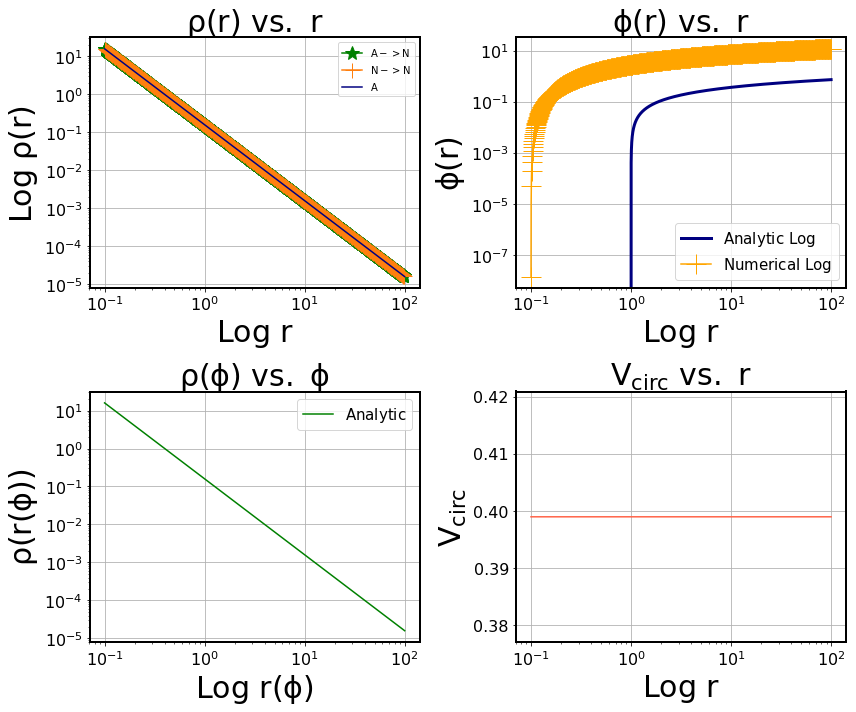

In [362]:
# create figure object
fig = plt.figure(1)
fig.set_figheight(10)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(221)
plt.grid(True)

# ploting

plt.plot(r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized,
         'green',marker="*",markersize=15,markevery=100, label=r'$\mathrm{A -> N}$')
plt.plot(r_iso_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test, 'tab:orange',marker="+"
         ,markersize=15,markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_iso, rho_of_r_analytic_iso, 'navy', label=r'$\mathrm{A}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


# create axis space
ax = plt.subplot(222)
plt.grid(True)

# ploting
##ploting
plt.plot(r_array_2_iso, phi_of_r_analytic_iso,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')
plt.plot(_phi_of_r_x_vals,phi_of_r_numerical,marker="+",color="orange",markersize=20,markevery=100,label=r'$\mathrm{Numerical\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


# create axis space
ax = plt.subplot(223)
plt.grid(True)

# ploting
# plt.plot(phi_iso_sphere_of_r_analytic_py(r_array_2),rho_iso_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_iso, rho_of_r_of_phi_iso,
         color='green', label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$', size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(224)
plt.grid(True)

# ploting
plt.plot(r_array_2_iso, vcirc_of_r_analytic(r_array_2_iso,_geometry=_geometry), color='tomato')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.tight_layout()

## isothermal Sphere: Density vs potential and it's derivatives

In [ ]:
# fig = plt.figure(3)
# fig.set_figheight(6)
# fig.set_figwidth(15)

# #create axis object
# ax = plt.subplot(131)
# plt.grid(True)

# ##ploting
# plt.plot(r_iso, rho_of_r_analytic,
#          label=r'$\mathrm{Analytic}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{Log\ \phi (r)}$',size=30)
# plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)

# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
# plt.semilogx()
# plt.legend(fontsize=15)
# plt.tight_layout()

# #create axis object
# ax = plt.subplot(132)
# plt.grid(True)

# ##ploting
# plt.plot(-drho_dr,rho_of_r_analytic,label=r'$\mathrm{numerical}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{Log\ -\frac{\mathrm{d} \phi(r)}{\mathrm{d}r}}$',size=30)
# plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)
# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
# plt.semilogx()
# plt.legend(fontsize=13)
# plt.tight_layout()

# ax = plt.subplot(133)
# plt.grid(True)


# ##ploting
# plt.plot(d2rho_dr2, rho_of_r_analytic,label=r'$\mathrm{numerical}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \phi}{\mathrm{d}r^2}}$',size=30)
# plt.ylabel(r'$\mathrm{\rho(r) }$',size=30)
# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# # plt.semilogy()
# # plt.semilogx()
# plt.legend(fontsize=15)
# plt.tight_layout()

# # plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \omega}{\mathrm{d}\theta^2}}$',size=30)

# Plummer Sphere

## Inputs

In [363]:
_N = 100000
r_array_2_plum = np.logspace(-1,2,_N) # 0.1 to 100

## Variables for plotting 

In [364]:
# Top Row
_geometry = "plum"

# Phi of r
r_plum, phi_of_r_analytic_plum = r_array_2_plum, phi_of_r_analytic(
    r_array_2_plum, _geometry=_geometry)


# rho of r
r_plum, rho_of_r_analytic_plum = r_array_2_plum, rho_of_r_analytic(
    r_array_2_plum, _geometry=_geometry)

# rho of r and derivatives
# Poisson normalized
r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_of_r_poisson_numerical(
    _r=r_plum, _phi_func_array=phi_of_r_analytic_plum,_rho_func_array=rho_of_r_analytic_plum,
    _deriv_func=take_deriv, _normalize=True)


# r of phi 
r_of_phi_plum, rho_of_r_of_phi_plum = r_of_phi_analytic(
    r_array_2_plum), rho_of_r_analytic(_r=r_of_phi_analytic(r_array_2_plum, _geometry=_geometry))

# phi of r numerical

_phi_of_r_x_vals, phi_of_r_numerical = phi_solver_of_rho(_r=r_plum, _analytic_rho=rho_of_r_analytic_plum,
                                                         _analytic_phi=phi_of_r_analytic_plum,
                                                         _int_function=trap_function, _normalize=False)

# rho(r) analytic -> phi(r) numerical -> rho(r) numerical
# logspace
r_plum_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test = rho_of_r_poisson_numerical(
    _phi_of_r_x_vals, _phi_func_array=phi_of_r_numerical, _rho_func_array=rho_of_r_analytic_plum,
    _deriv_func=take_deriv, _normalize=True)


# r_first_deriv, drho_dr  = take_deriv(rho_of_r_analytic(r_array_2_plum,_geometry=_geometry),_x=r_array_2_plum,_n=1)

# # second derivative`
# r_second_derive, d2rho_dr2  = take_deriv(rho_of_r_analytic(r_array_2_plum,_geometry=_geometry),_x=r_array_2_plum,_n=2)

_Grav_const is one
_Grav_const is one
_Grav_const is one


## Plots 

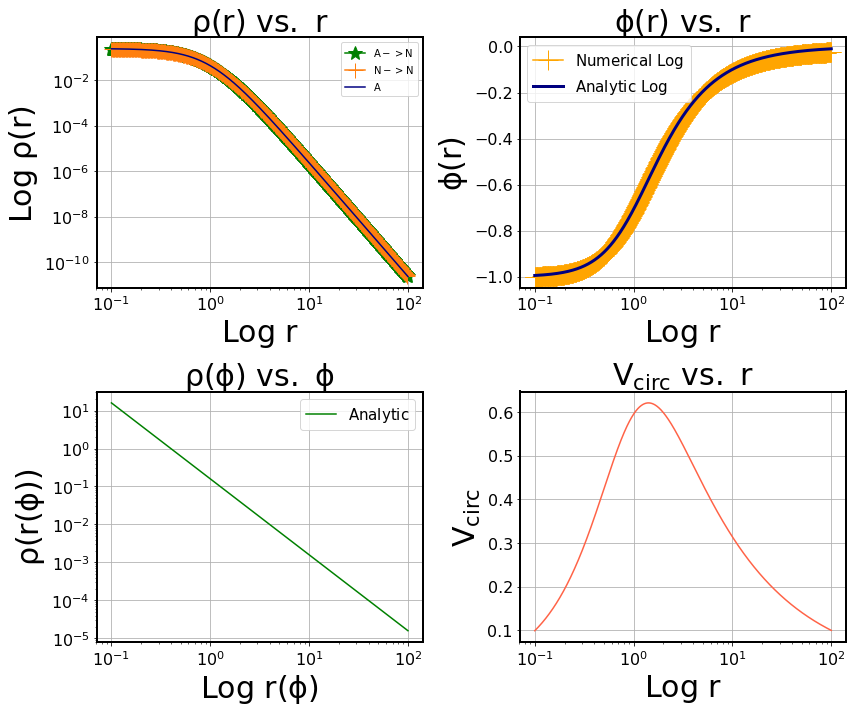

In [365]:
# create figure object
fig = plt.figure(2)
fig.set_figheight(10)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(221)
plt.grid(True)

# ploting

plt.plot(r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized,
         'green',marker="*",markersize=15,markevery=100, label=r'$\mathrm{A -> N}$')
plt.plot(r_plum_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test, 'tab:orange',marker="+"
         ,markersize=15,markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_plum, rho_of_r_analytic_plum, 'navy', label=r'$\mathrm{A}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


# create axis space
ax = plt.subplot(222)
plt.grid(True)

# ploting
##ploting
plt.plot(_phi_of_r_x_vals,phi_of_r_numerical-1,marker="+",color="orange",markersize=20,markevery=100,label=r'$\mathrm{Numerical\ Log}$')
plt.plot(r_array_2_plum, phi_of_r_analytic_plum,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


# create axis space
ax = plt.subplot(223)
plt.grid(True)

# ploting
# plt.plot(phi_plum_sphere_of_r_analytic_py(r_array_2),rho_plum_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_plum, rho_of_r_of_phi_plum,
         color='green', label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$', size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(224)
plt.grid(True)

# ploting
plt.plot(r_array_2_plum, vcirc_of_r_analytic(r_array_2_plum,_geometry=_geometry), color='tomato')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.tight_layout()

In [ ]:
def cumu_trap_function(_func, _anti_func, _a, _b, _N, _coordinates="cartesian",
                  _number=1):

    # create intervals
    _x = np.linspace(_a, _b, _N+1)  # N intervals

    # def dx
    _dx = (_b - _a)/_N


    _result = np.zeros(len(_x))
    if _coordinates == "spherical_polar":
        for ii in range(1,len(_x)):
        # call func interval, stars with a[1] to a[2]
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)

            # integrate over interval
            _result[ii] = (4.0*np.pi*(_dx/2.0)) * np.sum(_f[1:] + _f[:-1])
            
        if _number == 2:
            second_integral = np.zeros(len(_x))
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)
            

    if _coordinates == "cartesian":
        for ii in range(1,len(_x)):
            _f = _func(_x)

            # call func interval, stars with a[1] to a[2]
            _f = _func(_x[ii-1:ii+1])

            # integrate over interval
            _result[ii] = (_dx/2.0) * np.sum(_f[1:] + _f[:-1])
            
        if _number == 2:
            second_integral = np.zeros(len(_x))
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)
  
    return _result



## Dehnen Density Models

In [18]:
def rho_dehnen(_r,_p0=1,_a=1,_alpha=1,_beta=3):
    #default is NFW
    _term_a = (_r/_a)**_alpha
    _term_b = (1.0 + (_r/_a)) ** (_beta-_alpha)
    _calc = _p0 /(_term_a*_term_b)
    return _calc

def NFW_potential(_r,_p0=1,_a=1,_Grav_constant=1):
    _constants = -4.0*np.pi*_Grav_constant*_p0*(_a**2.0)
    _fraction  = np.log(1.0 + (_r/_a)) / (_r/_a)
    _calc = _constants * _fraction
    return _calc

def HERN_potential(_r,_p0=1,_a=1,_Grav_constant=1):
    _constants = -4.0*np.pi*_Grav_constant*_p0*(_a**2.0)
    _fraction  =  1.0 / (2.0*(1.0 + (_r/_a)))
    _calc = _constants * _fraction
    return _calc
    
            

## NFW Profile


## Variables for plotting 

In [367]:
_N = 100000
r_array_2_NFW = np.logspace(-1,5,_N) # 0.1 to 1e5

In [368]:
# Rho of r
r_NFW, rho_of_r_analytic_NFW = r_array_2_NFW, rho_dehnen(
    _r=r_array_2_NFW, _p0=1, _a=1, _alpha=1, _beta=3)

#phi of r analytic

phi_of_r_analytic_NFW = NFW_potential(_r=r_array_2_NFW,_p0=1,_a=1,_Grav_constant=1)

# phi of r numerical

_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW = phi_solver_of_rho(_r=r_array_2_NFW, _analytic_rho=rho_of_r_analytic_NFW,
                                                                 _analytic_phi=phi_of_r_analytic_NFW,
                                                                 _int_function=trap_function, _normalize=True)
#fix phi of r numerical
# adjust = max(phi_of_r_numerical_NFW)-max(phi_of_r_analytic_NFW)

# phi_of_r_numerical_NFW = phi_of_r_numerical_NFW - adjust

# Rho of R numerical
x_val_NFW, numerical_rho_of_r_NFW = rho_of_r_poisson_numerical(
    _r=r_array_2_NFW, _phi_func_array=phi_of_r_analytic_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=True)

# Rho of R numerical from phi_of_r numerical
x_val_NFW_NN, numerical_rho_of_r_NFW_NN = rho_of_r_poisson_numerical(
    _r=_phi_of_r_x_vals_NFW, _phi_func_array=phi_of_r_numerical_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=False)


#circular velocity numerical

_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW = take_deriv(_x= _phi_of_r_x_vals_NFW,
                                                              _y=phi_of_r_numerical_NFW)

vcirc_of_r_numerical_NFW = np.sqrt(_vcirc_of_r_x_vals_NFW * np.abs(vcirc_of_r_numerical_NFW))



_Grav_const is one
_Grav_const is one
_Grav_const is one


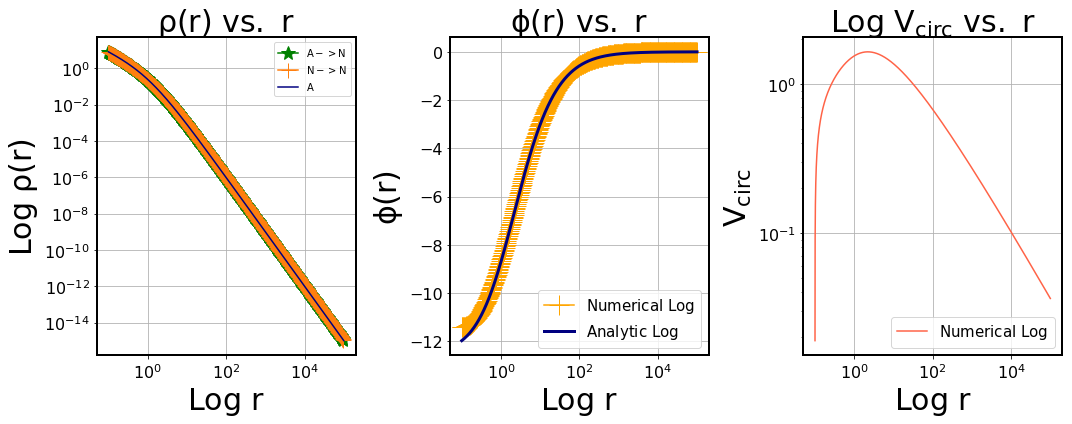

In [369]:
fig = plt.figure(3)
fig.set_figheight(6)
fig.set_figwidth(15)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(x_val_NFW, numerical_rho_of_r_NFW,'green',marker="*",markersize=15,markevery=200,
         label=r'$\mathrm{A -> N}$')
plt.plot(x_val_NFW_NN, numerical_rho_of_r_NFW_NN, 'tab:orange',marker="+",markersize=15,
         markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_NFW, rho_of_r_analytic_NFW, 'navy', label=r'$\mathrm{A}$')

# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()

# create axis space
ax = plt.subplot(132)
plt.grid(True)

# ploting
##ploting
plt.plot(_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW,marker="+",color="orange",markersize=20,markevery=200,label=r'$\mathrm{Numerical\ Log}$')
plt.plot(r_NFW, phi_of_r_analytic_NFW,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(133)
plt.grid(True)

# ploting
plt.plot(_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW, color='tomato',label=r'$\mathrm{Numerical\ Log}$')

# labeling
plt.title(r'$\mathrm{Log\ V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.semilogy()
plt.legend(fontsize=15)
plt.tight_layout()

# Rotation Curves

## Inputs 

In [370]:
# radius dist
inputs_RC = (np.logspace(18,26,100)) # m 

#DM Halo
_p0_DM = 8.54e-26 # g cm^-3
_a_DM = 1.23e23  # cm
#stars
_p0_STARS = 7.95e-24  # g cm^-3
_a_STARS = 1.54e22  # cm

## Define Density Distributions

In [371]:
# DM Halo density distribution
DM_rho_dist_NFW = rho_dehnen(_r=inputs_RC,_p0=_p0_DM,_a=_a_DM,_alpha=1,_beta=3)

# Stars Density distribution
STARS_rho_dist_HERN = rho_dehnen(_r=inputs_RC,_p0=_p0_STARS,_a=_a_STARS,_alpha=1,_beta=4)

# STARS + DM Density distribution
TOT_rho_dist = DM_rho_dist_NFW + STARS_rho_dist_HERN



## Variables for plotting

In [372]:
# phi of r analytic
_Grav_constant_cgs = 6.67e-8 # cgs

# DM
phi_of_r_analytic_DM = NFW_potential(_r=inputs_RC*cm_to_pc,_p0=_p0_DM*cgs_rho_to_solar_pc_rho,_a=_a_DM*cm_to_pc,_Grav_constant=G_solar_mass)

# STARS
phi_of_r_analytic_STARS = HERN_potential(_r=inputs_RC,_p0=_p0_STARS,_a=_a_STARS,_Grav_constant=_Grav_constant_cgs)

#PHI of R Numerical
#DM 
_phi_of_r_x_vals_DM, phi_of_r_numerical_DM = phi_solver_of_rho(_r=inputs_RC*cm_to_pc, _analytic_rho=DM_rho_dist_NFW,
                                                                 _analytic_phi=phi_of_r_analytic_DM,
                                                                 _int_function=trap_function, _Grav_const=_Grav_constant_cgs, _normalize=True)
# STARS
#DM 
_phi_of_r_x_vals_STARS, phi_of_r_numerical_STARS = phi_solver_of_rho(_r=inputs_RC, _analytic_rho=STARS_rho_dist_HERN,
                                                                 _analytic_phi=phi_of_r_analytic_STARS,
                                                                _int_function=trap_function, _Grav_const=_Grav_constant_cgs, _normalize=True)



#circular velocity ANALYTIC
# DM
_vcirc_of_r_x_vals_DM_A, _phi_of_r_analytic_dir_DM = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_DM)

vcirc_of_r_analytic_DM = np.sqrt(_vcirc_of_r_x_vals_DM_A * np.abs(_phi_of_r_analytic_dir_DM))

# STARS
_vcirc_of_r_x_vals_STARS_A, _phi_of_r_analytic_dir_STARS = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_STARS)

vcirc_of_r_analytic_STARS = np.sqrt(_vcirc_of_r_x_vals_STARS_A * np.abs(_phi_of_r_analytic_dir_STARS))

# ANALYTIC TOTAL

_vcirc_of_r_x_vals_TOT_A, _phi_of_r_analytic_dir_TOT = take_deriv(_x= inputs_RC,
                                                              _y=phi_of_r_analytic_DM+
                                                                  phi_of_r_analytic_STARS)

vcirc_of_r_analytic_TOT = np.sqrt(_vcirc_of_r_x_vals_DM_A * np.abs(_phi_of_r_analytic_dir_TOT))





#circular velocity numerical
# DM
_vcirc_of_r_x_vals_DM, vcirc_of_r_numerical_DM = take_deriv(_x= _phi_of_r_x_vals_DM,
                                                              _y=phi_of_r_numerical_DM)

vcirc_of_r_numerical_DM = np.sqrt(_vcirc_of_r_x_vals_DM * np.abs(vcirc_of_r_numerical_DM))

# STARS
_vcirc_of_r_x_vals_STARS, vcirc_of_r_numerical_STARS = take_deriv(_x= _phi_of_r_x_vals_STARS,
                                                              _y=phi_of_r_numerical_STARS)

vcirc_of_r_numerical_STARS = np.sqrt(_vcirc_of_r_x_vals_STARS * np.abs(vcirc_of_r_numerical_STARS))

# Numerical TOTAL
_vcirc_of_r_x_vals_TOT_N, _phi_of_r_numerical_dir_TOT = take_deriv(_x= _phi_of_r_x_vals_STARS,
                                                              _y=phi_of_r_numerical_DM+
                                                                  phi_of_r_numerical_STARS)

vcirc_of_r_numerical_TOT = np.sqrt(_vcirc_of_r_x_vals_TOT_N * np.abs(_phi_of_r_numerical_dir_TOT))





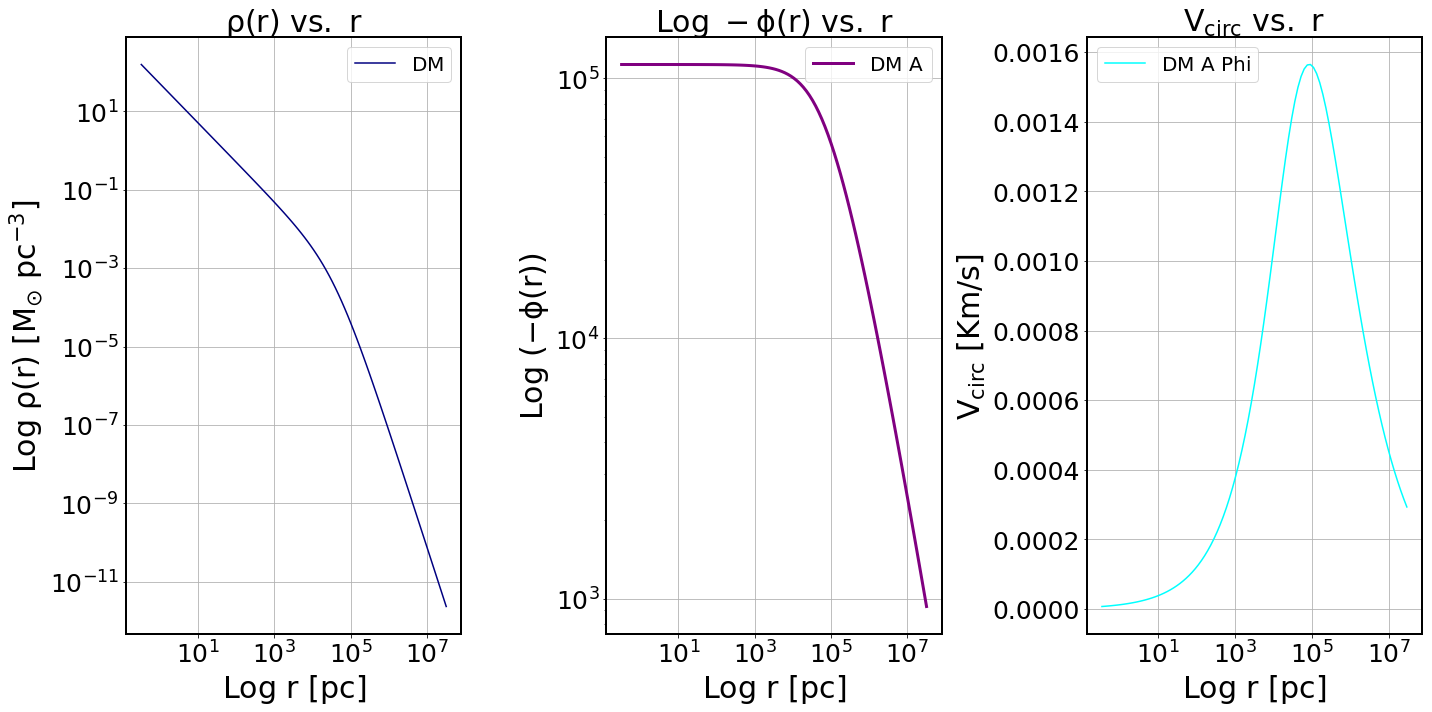

In [373]:
fig = plt.figure(4)
fig.set_figheight(10)
fig.set_figwidth(20)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(inputs_RC*cm_to_pc, DM_rho_dist_NFW*cgs_rho_to_solar_pc_rho,'Navy',label=r'$\mathrm{DM}$')
# plt.plot(inputs_RC*cm_to_pc, STARS_rho_dist_HERN*cgs_rho_to_solar_pc_rho, 'tab:orange',label=r'$\mathrm{Stars}$')
# plt.plot(inputs_RC*cm_to_pc, TOT_rho_dist*cgs_rho_to_solar_pc_rho, 'tab:green',marker="*",label=r'$\mathrm{DM\ +\ STARS}$')

# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r)\ [M_{\odot}\ pc^{-3}] }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()

# create axis space
ax = plt.subplot(132)
plt.grid(True)

# ploting
# plt.plot(_phi_of_r_x_vals_DM, -phi_of_r_numerical_DM,color="orange",marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ N}$')
# plt.plot(_phi_of_r_x_vals_STARS*cm_to_pc, -phi_of_r_numerical_STARS,color='navy',marker="+",markevery=50,markersize=20,linewidth=3,label=r'$\mathrm{STARS\ N}$')
# plt.plot(_phi_of_r_x_vals_STARS*cm_to_pc, -phi_of_r_numerical_STARS + -phi_of_r_numerical_DM,color='maroon',marker="+",markevery=50,markersize=20,linewidth=3,label=r'$\mathrm{STARS\ +\ DM\ N}$')

plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_DM,color='purple',linewidth=3,label=r'$\mathrm{DM\ A}$')
# plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_STARS,color='green',linewidth=3,label=r'$\mathrm{STARS\ A}$')
# plt.plot(inputs_RC*cm_to_pc,-phi_of_r_analytic_STARS+-phi_of_r_analytic_DM,color='cyan',linewidth=3,label=r'$\mathrm{STARS\ +\ DM\ A}$')
# labeling
plt.title(r'$\mathrm{Log\ -\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{Log\ (-\phi(r))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()


# create axis space
ax = plt.subplot(133)

plt.grid(True)

# ploting

plt.plot(_vcirc_of_r_x_vals_DM_A*cm_to_pc, vcirc_of_r_analytic_DM*cm_to_km, color='cyan',label=r'$\mathrm{DM\ A\ Phi}$')
#  plt.plot(_vcirc_of_r_x_vals_STARS_A*cm_to_pc, vcirc_of_r_analytic_STARS*cm_to_km, color='tab:blue',label=r'$\mathrm{STARS\ A\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_TOT_A*cm_to_pc, vcirc_of_r_analytic_TOT*cm_to_km, color='tab:red',label=r'$\mathrm{DM\ +\ Stars\ A\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_DM*cm_to_pc, vcirc_of_r_numerical_DM*cm_to_km, color='Navy',marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ N\ Phi}$')
# plt.plot(_vcirc_of_r_x_vals_STARS*cm_to_pc, vcirc_of_r_numerical_STARS*cm_to_km, color='tab:orange',marker="+",markevery=50,markersize=20,label=r'$\mathrm{STARS\ N\Phi }$')
# plt.plot(_vcirc_of_r_x_vals_TOT_N*cm_to_pc, vcirc_of_r_numerical_TOT*cm_to_km, color='tab:green',marker="+",markevery=50,markersize=20,label=r'$\mathrm{DM\ +\ Stars\ N\ \Phi}$')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}\ [Km/s]}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)

plt.semilogx()
# plt.semilogy()
plt.legend(fontsize=20)

plt.tight_layout()

In [216]:
max_analytic = max(phi_of_r_analytic_STARS + phi_of_r_analytic_DM)
print("order of magnitude",math.floor(math.log10(np.abs(max_analytic))))


order of magnitude 12


## Numerical Distribution function

## Testing with jagged arrays

In [375]:
def integrand_array_func(_epsilon_array,_rho_array, _psi_array):
    _int_bin = np.zeros((_epsilon_array.size,_psi_array.size-1))
    for ii in range(0,_epsilon_array.size):
        for jj in range(0,_psi_array.size-1):
            _d_rho               = np.diff(_rho_array[jj:jj+2])
            _d_PSI               = np.diff(_psi_array[jj:jj+2])
            _PSI_bin_center      = 0.5 * np.sum(_psi_array[jj:jj+2])
            if _d_PSI.size != 1 or _PSI_bin_center.size != 1 or _d_rho.size != 1:
                print (jj)
                raise ValueError("d's in integrand array func is messed up")
                
            if _PSI_bin_center > _epsilon_array[ii]:
                print ("stopped")
                print ("ii",ii)
                print ("jj",jj)
                break
#                 raise ValueError("nan in integrand_array_func")
            else:
                _d_PSI = _d_PSI.item(0)
            _sqrt_term           = np.sqrt(_epsilon_array[ii]-_PSI_bin_center)
            if _sqrt_term == np.nan or _sqrt_term == 0:
                print ("this occured at the iith element ->",ii)
                raise ValueError("your sqrt in the integrand array is 0 or nan")
                
            _calc = (_d_rho/_d_PSI)*(_d_PSI/_sqrt_term)
            if _calc < 0:
                print (jj)
                raise ValueError("you have a negative in your integrand array")
            _int_bin[ii,jj] = _calc
    return _int_bin

def integrate_derived_integrand_array(_bin_centers,_integrand_array,_epsilon_array,_PSI_array):
    _test_final_bin  = np.zeros(_integrand_array.shape[0])
    _right_edges_bin = np.zeros(_integrand_array.shape[0])
    
    previous_val = 0
    
    for aa in range(0,_integrand_array.shape[0]-3):
    

        
        _PSI_limits = _PSI_array[:aa+3][-1]

        _bin_centers_iterate = _bin_centers[_bin_centers < _PSI_limits]
#         print (_bin_centers_iterate,"bin centers")
        _row = _integrand_array[aa][:np.count_nonzero(_integrand_array[aa])]
        _row = _row[:_bin_centers_iterate.size]
#         print (_bin_centers_iterate)
#         print (_row)
#         print (_row,"integrand row")
        
        if _bin_centers_iterate.size < 2 or _row.size < 2 :
            print (aa,"th value")
            raise ValueError("Your bin centers or integrand array are fucked up")
        
        temp = _PSI_array[aa:aa+2]
        if len(temp) == 0:
            print (aa)
            raise ValueError('psi value array is messed up')
        
        if np.diff(_PSI_array[aa:aa+2]) < 1e-16:
            raise ValueError("Your PSI values are not changing")
        
        if np.diff(_bin_centers[aa:aa+2]) < 1e-16:
            raise ValueError("Your bin_centers_PSI values are not changing")        
        
        if np.isnan(_row).sum() > 0 or np.count_nonzero(_row) != _row.size:
            print (np.count_nonzero(_row))
            print (_row)
            print ("this many nans",np.isnan(_row).sum(),"this many zeros",_row.size-np.count_nonzero(_row))
            raise ValueError ("you have a zero or nan in the integrand")
        
#         print ("right bfore integrating",_bin_centers_iterate,_row)
        _bin_edges, _num_integral= trap_function(_input_array=_bin_centers_iterate,
                                                 _function_array=_row,
                                                 _cumulative_anti=False)
        _test_final_bin[aa] = _num_integral
        if np.diff(np.array([previous_val,_num_integral])).item() < 0:
            print (aa)
            raise ValueError("Your integrand array is no longer increasing")
        if _PSI_limits == _PSI_array[-1]:
            break
    
    return np.array((_bin_edges,_test_final_bin))

# test_r_edges,test_int_array = integrate_derived_integrand_array(_bin_centers=_PSI_bin_centers,
#                                                               _integrand_array=_integrand_array_test)

def derive_integrated_array(_epsilon_array,_integrated_array):
    _bin_centers_final_f_e,_final_f_e = take_deriv(_x=_epsilon_array,_y=_integrated_array)

    return np.array((_bin_centers_final_f_e,_final_f_e))






#             _PSI_limits = _PSI_array[:aa+3][-1]
#             _bin_centers_iterate = _f_eps_bin_edges_array[_f_eps_bin_edges_array < _PSI_limits]
#     #         print (_bin_centers_iterate,"bin centers")
#             _row = _integrand_array[aa][:np.count_nonzero(_integrand_array[aa])]
#             _row = _row[:_bin_centers_iterate.size]


            
#             if _bin_centers_iterate.size < 2 or _row.size < 2 :
#                 print (aa,"th value")
#                 raise ValueError("Your bin centers or integrand array are fucked up")

#             if np.diff(_f_eps_bin_edges_array[aa:aa+2]) < 1e-16:
#                 raise ValueError("Your F(E) bin edges values are not changing")

#             if np.diff(_PSI_array[aa:aa+2]) < 1e-16:
#                 raise ValueError("Your bin_centers_PSI values are not changing") 



### Def f(epsilon)

In [376]:
# cgs
def f_E_abel(_r, _epsilon_array):
    
    # define constants
    _constants = 1.0 / ((np.pi**2.0) * np.sqrt(8.0))
    
    # define DM and stars potential distributions
    _DM_potential = NFW_potential(
        _r=_r*cm_to_pc, _p0=_p0_DM*cgs_rho_to_solar_pc_rho, _a=_a_DM*cm_to_pc, _Grav_constant=G_solar_mass)
#     _STARS_potential = HERN_potential(
#         _r=_r, _p0=_p0_STARS, _a=_a_STARS, _Grav_constant=_Grav_constant_cgs)
    
    # sum potential distributions
    _TOT_Potential = _DM_potential# + _STARS_potential
    
    # define phi_0 constant
    _phi_constant = max(_TOT_Potential)
#     print ("the constant is ", _phi_constant)
    # define PSI
    _TOT_PSI = -_TOT_Potential + _phi_constant
    _TOT_PSI = _TOT_PSI[::-1]
    #
    
    # Define DM and Star density distributions
    _DM_rho_dist = rho_dehnen(
        _r=_r*cm_to_pc, _p0=_p0_DM*cgs_rho_to_solar_pc_rho, _a=_a_DM*cm_to_pc, _alpha=1, _beta=3)
#     _STARS_rho_dist = rho_dehnen(
#         _r=_r, _p0=_p0_STARS, _a=_a_STARS, _alpha=1, _beta=4)
    
    # sum density distributions
    _TOT_density = _DM_rho_dist #+ _STARS_rho_dist
    _TOT_density = _TOT_density[::-1]
    
    # define integrand
    _integrand_array = integrand_array_func(_epsilon_array=_epsilon_array,
                                       _rho_array=_TOT_density,
                                       _psi_array=_TOT_PSI)
    
    for ii, value in enumerate(_integrand_array):
        for jj, integral_element in enumerate(np.diff(value)):
            if integral_element < 0:
                print (jj)
                print (np.diff(value))
                raise ValueError("you have a negative in your integrand function")
#     print (_integrand_array)
    
#     return _integrand_array
    # define Psi bin centers
    _PSI_bin_centers = ((_TOT_PSI[:-1] + _TOT_PSI[1:]) / 2.0)
    
    for ii, value in enumerate(np.diff(_PSI_bin_centers)):
        if value < 0:
            print (ii)
            raise ValueError("your psi bin centers are not increasing")



        
    
    # integrate before differentiation
    _right_edge_bins,_result = integrate_derived_integrand_array(_bin_centers=_PSI_bin_centers,
                                                                _integrand_array=_integrand_array,
                                                                _epsilon_array=_epsilon_array,
                                                                _PSI_array=_TOT_PSI)
    
    for ii, value in enumerate(_result):
        if value < 0:
            print (ii)
            raise ValueError("you have a negative in your BEFORE you take a derivative of the integrated result")

    for ii, value in enumerate(np.diff(_result[:np.count_nonzero(_result)])):
        if value < 0:
            print (np.diff(_result[:np.count_nonzero(_result)]))
            print (ii)
            raise ValueError("Your integrated result is not increasing monotonically for some reason")

#     # take derivative with respect to epsilon
    _bin_centers, _result, = derive_integrated_array(_epsilon_array=_epsilon_array,_integrated_array=_result)
    
#     for ii, value in enumerate(_result):
#         if value < 0:
#             print (ii)
#             raise ValueError("you have a negative in your AFTER you take a derivative of the integrated result")
    
    return np.array((_bin_centers[:np.count_nonzero(_result)],_constants*_result[:np.count_nonzero(_result)],_TOT_PSI,_PSI_bin_centers))




### Test f(epsilon)

In [377]:
# r inputs
# inputs_R = (np.linspace(1e14,1e25,20)*100)
inputs_R = (np.logspace(18,26,100))
# epsilons
# inputs_epsilon = (np.linspace(22,26,40))
inputs_epsilon = (np.logspace(3,5,100))

#
# _,int_array_test = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon)
f_e_bin_edges,f_e_array,PSI_TOT_array, PSI_bin_centers = f_E_abel(_r=inputs_R, _epsilon_array=inputs_epsilon)




stopped
ii 0
jj 5
stopped
ii 1
jj 5
stopped
ii 2
jj 5
stopped
ii 3
jj 5
stopped
ii 4
jj 5
stopped
ii 5
jj 5
stopped
ii 6
jj 6
stopped
ii 7
jj 6
stopped
ii 8
jj 6
stopped
ii 9
jj 6
stopped
ii 10
jj 6
stopped
ii 11
jj 7
stopped
ii 12
jj 7
stopped
ii 13
jj 7
stopped
ii 14
jj 7
stopped
ii 15
jj 7
stopped
ii 16
jj 8
stopped
ii 17
jj 8
stopped
ii 18
jj 8
stopped
ii 19
jj 8
stopped
ii 20
jj 8
stopped
ii 21
jj 9
stopped
ii 22
jj 9
stopped
ii 23
jj 9
stopped
ii 24
jj 9
stopped
ii 25
jj 10
stopped
ii 26
jj 10
stopped
ii 27
jj 10
stopped
ii 28
jj 10
stopped
ii 29
jj 11
stopped
ii 30
jj 11
stopped
ii 31
jj 11
stopped
ii 32
jj 11
stopped
ii 33
jj 12
stopped
ii 34
jj 12
stopped
ii 35
jj 12
stopped
ii 36
jj 13
stopped
ii 37
jj 13
stopped
ii 38
jj 13
stopped
ii 39
jj 13
stopped
ii 40
jj 14
stopped
ii 41
jj 14
stopped
ii 42
jj 14
stopped
ii 43
jj 15
stopped
ii 44
jj 15
stopped
ii 45
jj 15
stopped
ii 46
jj 15
stopped
ii 47
jj 16
stopped
ii 48
jj 16
stopped
ii 49
jj 16
stopped
ii 50
jj 17
stopped
ii 51
j

ValueError: you have a negative in your integrand function

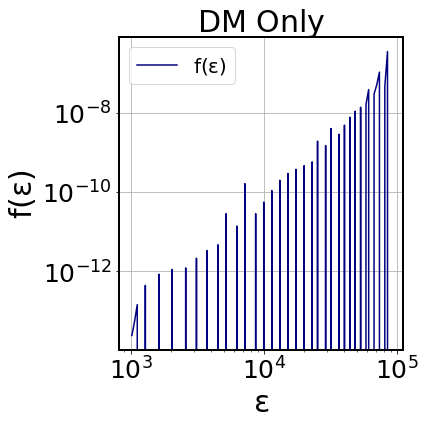

In [378]:
fig = plt.figure(5)
fig.set_figheight(6)
fig.set_figwidth(6)

# create axis object
ax = plt.subplot(111)
plt.grid(True)

# ploting

plt.plot(f_e_bin_edges,f_e_array,'Navy',label=r'$\mathrm{f(\epsilon)}$')
# plt.axvline(f_e_bin_edges[61])
# labeling
plt.title(r'$\mathrm{DM\ Only}$', size=30)
plt.xlabel(r'$\mathrm{\epsilon}$', size=30)
plt.ylabel(r'$\mathrm{f(\epsilon)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
# plt.xlim(-1e22,1e23)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()

### Recover rho  (r) 

In [201]:

def integrand_array_func_V2(_PSI_array,_f_eps_array,_f_eps_bin_edges_array):
    _int_bin = np.zeros((_PSI_array.size,_f_eps_array.size))
    print (len(_f_eps_array)-1)
    for ii in range(0,_PSI_array.size):
        for jj in range(0,_f_eps_array.size):       

#             print (_f_eps_array[jj:jj+2])
            f_eps_widths        = np.diff(_f_eps_array[jj:jj+2])
            if f_eps_widths.size < 1 or len(_f_eps_array[jj:jj+2]) == 0 and jj != len(_f_eps_array)-1:
                print (jj)
                raise ValueError("bin width is fucked up")
            
            # calc d_epslion
            
            d_new_eps           = np.diff(_f_eps_bin_edges_array[jj:jj+2])
            if _PSI_array[ii] > d_new_eps:
                break

            
            # Calc Bin Centers for Epsilon
            _eps_bin_centers    = 0.5 * np.sum(_f_eps_bin_edges_array[jj:jj+2])
            
            # Calc sqrt term
            _sqrt_term          = np.sqrt(2 * (_PSI_array[ii] -_eps_bin_centers))
            
                

       
            _calc = f_eps_widths*_sqrt_term*_eps_bin_centers
            if _calc < 0 or _calc == np.nan:
                raise ValueError("your int array is fucked up")
            _int_bin[ii,jj] = _calc
    return _int_bin

def integrate_integrand_array(_bin_centers,_integrand_array,_epsilon_array):
    _test_final_bin  = np.zeros(_integrand_array.shape[0])
    _right_edges_bin = np.zeros(_integrand_array.shape[0])
#     print (_integrand_array.shape[0])
#     stop
    
    for aa in range(0,_integrand_array.shape[0]):
        
        
        
        _EPS_limits = _epsilon_array[:aa+3][-1]
        _bin_centers_iterate = _bin_centers[_bin_centers < _EPS_limits]
#         print (_bin_centers_iterate,"bin centers")
        _row = _integrand_array[aa][:np.count_nonzero(_integrand_array[aa])]
        _row = _row[:_bin_centers_iterate.size]
        
    

        if np.isnan(_row).sum() > 0 or np.count_nonzero(_row) != _row.size:
            print (np.count_nonzero(_row))
            print (_row)
            print ("this many nans",np.isnan(_row).sum(),"this many zeros",_row.size-np.count_nonzero(_row))
            raise ValueError ("you have a zero or nan in the integrand")
 

        _bin_edges, _num_integral= trap_function(_input_array=_bin_centers_iterate,
                                                 _function_array=_row,
                                                 _cumulative_anti=False)
        
        _test_final_bin[aa] = _num_integral
        _right_edges_bin[aa]= _bin_edges
    
    return np.array((_right_edges_bin,_test_final_bin))

In [202]:

rho_of_r_eps = integrand_array_func_V2(_PSI_array=PSI_bin_centers,
                                        _f_eps_array=f_e_array,
                                        _f_eps_bin_edges_array=f_e_bin_edges)

rho_r_bin_edges,rho_r_array = integrate_integrand_array(_bin_centers=PSI_bin_centers,
                                                        _integrand_array=rho_of_r_eps,
                                                        _epsilon_array=f_e_bin_edges)



48
48


/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


ValueError: bin width is fucked up

In [150]:
rho_of_r_eps.shape

NameError: name 'rho_r_bin_edges' is not defined

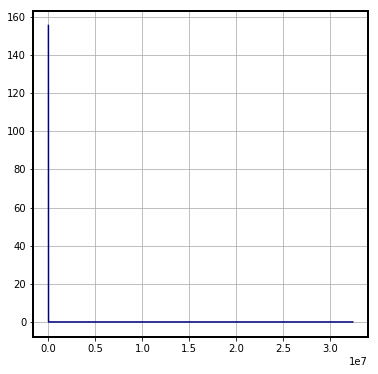

In [131]:
fig = plt.figure(8)
fig.set_figheight(6)
fig.set_figwidth(6)

# create axis object
ax = plt.subplot(111)
plt.grid(True)

# ploting

plt.plot(inputs_RC*cm_to_pc, DM_rho_dist_NFW*cgs_rho_to_solar_pc_rho,'Navy',label=r'$\mathrm{DM\ A}$')
plt.plot(rho_r_bin_edges*cm_to_pc, rho_r_array*cgs_rho_to_solar_pc_rho,'tab:red',marker="+",markersize=15,
         label=r'$\mathrm{DM\ 5.149}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r\ [pc]}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r)\ [M_{\odot}\ pc^{-3}] }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=20)
plt.tight_layout()

In [42]:
f = np.array([])

In [43]:
f.size

In [58]:
x = np.linspace(0,8)
print (x)
f = x**2
_, int = trap_function(_input_array=x[:-1],_function_array=f)

[0.         0.16326531 0.32653061 0.48979592 0.65306122 0.81632653
 0.97959184 1.14285714 1.30612245 1.46938776 1.63265306 1.79591837
 1.95918367 2.12244898 2.28571429 2.44897959 2.6122449  2.7755102
 2.93877551 3.10204082 3.26530612 3.42857143 3.59183673 3.75510204
 3.91836735 4.08163265 4.24489796 4.40816327 4.57142857 4.73469388
 4.89795918 5.06122449 5.2244898  5.3877551  5.55102041 5.71428571
 5.87755102 6.04081633 6.20408163 6.36734694 6.53061224 6.69387755
 6.85714286 7.02040816 7.18367347 7.34693878 7.51020408 7.67346939
 7.83673469 8.        ]


ValueError: setting an array element with a sequence.

In [129]:
f = np.arange(9)

In [130]:
print (f)

[0 1 2 3 4 5 6 7 8]


In [128]:
f[-1]

8